### Data Dictionary

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| dataset|	Master data set for the case study|
| esn|	Engine Serial Number |
| unit|	Engine unit number assigned to a given ESN|
| flight cycle|	Several flight cycles are recorded for a given ESN|
| datetime|	Date and time when the engine measurements were taken|
| operator|	3-4 letter unique code for a specific airline|
| depart_icao|	4 letter code for the departure airport|
| destination_icao|	4 letter code for the destination airport|
| hpc_eff_mod|	High Pressure Compressor (HPC) efficiency modifier|
| hpc_flow_mod|	High Pressure Compressor (HPC) flow modifier|
| tra|	Throttle Resolver Angle|
| t2|	Total temperature at fan inlet|
| t24|	Total temperature at Low Pressure Compressor (LPC) outlet|
| t30|	Total temperature at High Pressure Compressor (HPC) outlet|
| t50|	Total temperature at Low Pressure Turbine (LPT) outlet|
| p2|	Pressure at fan inlet|
| p15|	Total pressure in bypass-duct|
| p30|	Total pressure at High Pressure Compressor (HPC) outlet|
| nf|	Physical fan speed|
| nc|	Physical core speed|
| epr|	Engine pressure ratio (p30/p2)|
| ps30|	Static pressure at HPC outlet|
| phi|	Ratio of fuel flow to ps30|
| nrf|	Corrected fan speed|
| nrc|	Corrected core speed|
| bpr|	Bypass Ratio|
| farb|	Burner fuel-air ratio|
| htbleed|	Bleed Enthalpy|
| nf_dmd|	Demanded fan speed|
| pcnfr_dmd|	Demanded corrected fan speed|
| w31|	HPT coolant bleed|
| w32|	LPT coolant bleed|
| rul|	Remaining Useful Life|

### Summary

The goal of the exercise is to predict the RUL for the LAST flight cycle for a given ESN

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import shap

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import plot_importance

%matplotlib inline
sns.set_style('dark')
sns.set(font_scale=1.2)

from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE, RFECV, SelectKBest, f_classif, f_regression, chi2

from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error,r2_score
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, accuracy_score
from sklearn.metrics import auc, f1_score, precision_score, recall_score, roc_auc_score


#import feature_engine.missing_data_imputers as mdi
#from feature_engine.outlier_removers import Winsorizer

import warnings
warnings.filterwarnings('ignore')

import pickle
from pickle import dump, load

np.random.seed(0)

from pycaret.regression import *

pd.set_option('display.max_columns',100)
#pd.set_option('display.max_rows',100)
pd.set_option('display.width', 1000)
np.set_printoptions(suppress=True)

### Data Exploration and Analysis

In [2]:
df = pd.read_csv("final.csv", parse_dates=['datetime'])

In [3]:
df

dataset     esn  unit  flight_cycle            datetime operator depart_icao destination_icao  hpc_eff_mod  hpc_flow_mod  tra      t2      t24      t30      t50     p2    p15     p30       nf       nc  epr   ps30     phi      nrf      nrc     bpr  farb  htbleed  nf_dmd  pcnfr_dmd    w31      w32  rul
0     test_FD001  999159    59            15 2018-01-04 17:23:30     FRON        KIND             KMCO      -0.0019        0.0002  100  518.67  1101.59  1581.43  1397.66  14.62  21.61  553.76  2387.98  9053.86  1.3  47.15  521.75  2388.00  8141.38  8.3718  0.03      390    2388        100  39.07  23.3881  119
1     test_FD001  999159    59             1 2017-12-31 20:29:57     FRON        KMCO             KCVG      -0.0008       -0.0004  100  518.67  1101.92  1589.29  1395.20  14.62  21.61  554.74  2387.96  9050.56  1.3  47.44  522.52  2388.02  8139.38  8.3801  0.03      390    2388        100  39.14  23.3486  119
2     test_FD001  999159    59            55 2018-01-09 12:13:13     FRON        KLAX             KATL       0.0008       -0.0001  100  518.67  1101.80  1577.44  1396.72  14.62  21.61  554.42  2387.97  9052.88  1.3  47.20  522.58  2388.04  8134.88  8.3841  0.03      393    2388        100  39.06  23.3695  119
3     test_FD001  999159    59             6 2018-01-02 06:49:26     FRON        KMKE             KMIA      -0.0009       -0.0002  100  518.67  1101.40  1579.85  1397.03  14.62  21.61  554.92  2388.00  9060.03  1.3  47.12  522.20  2388.00  8134.46  8.4105  0.03      391    2388        100  38.94  23.3968  119
4     test_FD001  999159    59            66 2018-01-10 09:13:00     FRON        KSAT             KONT       0.0003        0.0001  100  518.67  1101.92  1585.21  1406.96  14.62  21.61  554.56  2388.05  9061.70  1.3  47.12  522.33  2388.03  8134.46  8.4097  0.03      393    2388        100  38.98  23.4150  119
...          ...     ...   ...           ...                 ...      ...         ...              ...          ...           ...  ...     ...      ...      ...      ...    ...    ...     ...      ...      ...  ...    ...     ...      ...      ...     ...   ...      ...     ...        ...    ...      ...  ...
7858  test_FD001  999101     1            29 2018-01-05 07:48:43      PGT        LTAU             LTFJ       0.0014        0.0001  100  518.67  1101.62  1587.15  1398.11  14.62  21.61  554.15  2388.08  9046.11  1.3  47.42  522.39  2388.07  8133.13  8.4212  0.03      392    2388        100  39.02  23.3621  149
7859  test_FD001  999101     1            24 2018-01-04 12:21:10      PGT        LTCA             LTFJ      -0.0006       -0.0001  100  518.67  1101.99  1594.29  1400.15  14.62  21.61  553.27  2388.07  9043.32  1.3  47.29  522.06  2388.12  8130.70  8.4074  0.03      393    2388        100  38.94  23.3971  149
7860  test_FD001  999101     1             4 2018-01-01 07:27:35      PGT        EDDF             LTFJ       0.0042        0.0000  100  518.67  1102.11  1584.12  1406.42  14.62  21.61  554.07  2388.03  9045.29  1.3  47.28  521.38  2388.05  8132.90  8.3917  0.03      391    2388        100  39.00  23.3737  149
7861  test_FD001  999101     1            31 2018-01-05 11:49:42      PGT        LTAU             LTFJ      -0.0006        0.0004  100  518.67  1102.25  1581.22  1398.91  14.62  21.61  554.42  2388.08  9056.40  1.3  47.23  521.79  2388.06  8130.11  8.4024  0.03      393    2388        100  38.81  23.3552  149
7862  test_FD001  999101     1            11 2018-01-02 23:28:31      PGT        LTFJ             LTFH       0.0007       -0.0004  100  518.67  1101.71  1581.03  1403.83  14.62  21.61  554.69  2388.04  9051.67  1.3  47.23  521.95  2388.06  8132.38  8.3919  0.03      391    2388        100  39.06  23.3609  149

[7863 rows x 33 columns]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7863 entries, 0 to 7862
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   dataset           7863 non-null   object        
 1   esn               7863 non-null   int64         
 2   unit              7863 non-null   int64         
 3   flight_cycle      7863 non-null   int64         
 4   datetime          7863 non-null   datetime64[ns]
 5   operator          7863 non-null   object        
 6   depart_icao       7581 non-null   object        
 7   destination_icao  7497 non-null   object        
 8   hpc_eff_mod       7863 non-null   float64       
 9   hpc_flow_mod      7863 non-null   float64       
 10  tra               7863 non-null   int64         
 11  t2                7863 non-null   float64       
 12  t24               7863 non-null   float64       
 13  t30               7863 non-null   float64       
 14  t50               7863 n

In [5]:
df.describe(include='all')

dataset            esn         unit  flight_cycle             datetime operator depart_icao destination_icao  hpc_eff_mod  hpc_flow_mod     tra            t2          t24          t30          t50            p2          p15          p30           nf           nc           epr         ps30          phi          nrf          nrc          bpr          farb      htbleed  nf_dmd  pcnfr_dmd          w31          w32          rul
count         7863    7863.000000  7863.000000   7863.000000                 7863     7863        7581             7497  7863.000000   7863.000000  7863.0  7.863000e+03  7863.000000  7863.000000  7863.000000  7.863000e+03  7863.000000  7863.000000  7863.000000  7863.000000  7.863000e+03  7863.000000  7863.000000  7863.000000  7863.000000  7863.000000  7.863000e+03  7863.000000  7863.0     7863.0  7863.000000  7863.000000  7863.000000
unique           1            NaN          NaN           NaN                 5947        3         217              211          NaN           NaN     NaN           NaN          NaN          NaN          NaN           NaN          NaN          NaN          NaN          NaN           NaN          NaN          NaN          NaN          NaN          NaN           NaN          NaN     NaN        NaN          NaN          NaN          NaN
top     test_FD001            NaN          NaN           NaN  2018-01-14 18:44:00      AXM        WMKK             WMKK          NaN           NaN     NaN           NaN          NaN          NaN          NaN           NaN          NaN          NaN          NaN          NaN           NaN          NaN          NaN          NaN          NaN          NaN           NaN          NaN     NaN        NaN          NaN          NaN          NaN
freq          7863            NaN          NaN           NaN                    8     5045        1905             1562          NaN           NaN     NaN           NaN          NaN          NaN          NaN           NaN          NaN          NaN          NaN          NaN           NaN          NaN          NaN          NaN          NaN          NaN           NaN          NaN     NaN        NaN          NaN          NaN          NaN
first          NaN            NaN          NaN           NaN  2017-12-31 18:22:57      NaN         NaN              NaN          NaN           NaN     NaN           NaN          NaN          NaN          NaN           NaN          NaN          NaN          NaN          NaN           NaN          NaN          NaN          NaN          NaN          NaN           NaN          NaN     NaN        NaN          NaN          NaN          NaN
last           NaN            NaN          NaN           NaN  2018-07-24 07:04:02      NaN         NaN              NaN          NaN           NaN     NaN           NaN          NaN          NaN          NaN           NaN          NaN          NaN          NaN          NaN           NaN          NaN          NaN          NaN          NaN          NaN           NaN          NaN     NaN        NaN          NaN          NaN          NaN
mean           NaN  999153.244563    53.244563     78.918352                  NaN      NaN         NaN              NaN     0.000005      0.000005   100.0  5.186700e+02  1102.144751  1588.146187  1404.281850  1.462000e+01    21.609691   553.755804  2388.070207  9058.730584  1.300000e+00    47.416045   521.750237  2388.070242  8139.244662     8.425900  3.000000e-02   392.564034  2388.0      100.0    38.891049    23.335624    74.818390
std            NaN      28.643980    28.643980     55.198817                  NaN      NaN         NaN              NaN     0.002225      0.000296     0.0  5.059386e-11     0.401772     5.085923     5.984049  1.350117e-12     0.001731     0.690370     0.058583    11.310730  4.174704e-14     0.198469     0.571852     0.057399    10.054097     0.029418  1.040900e-15     1.237890     0.0        0.0     0.143092     0.084965    51.138268
min            NaN  999101.000000     1.000000      1.000000         

In [6]:
df.shape

(7863, 33)

In [7]:
df.columns

Index(['dataset', 'esn', 'unit', 'flight_cycle', 'datetime', 'operator', 'depart_icao', 'destination_icao', 'hpc_eff_mod', 'hpc_flow_mod', 'tra', 't2', 't24', 't30', 't50', 'p2', 'p15', 'p30', 'nf', 'nc', 'epr', 'ps30', 'phi', 'nrf', 'nrc', 'bpr', 'farb', 'htbleed', 'nf_dmd', 'pcnfr_dmd', 'w31', 'w32', 'rul'], dtype='object')

In [8]:
df['dataset'].value_counts()

test_FD001    7863
Name: dataset, dtype: int64

In [9]:
df['esn'].value_counts()

999149    292
999193    256
999131    206
999191    205
999181    198
         ... 
999109     27
999125     27
999185     18
999122     17
999101     16
Name: esn, Length: 80, dtype: int64

In [10]:
df['unit'].value_counts()

49    292
93    256
31    206
91    205
81    198
     ... 
25     27
33     27
85     18
22     17
1      16
Name: unit, Length: 80, dtype: int64

In [11]:
df['operator'].value_counts()

AXM     5045
PGT     1456
FRON    1362
Name: operator, dtype: int64

In [12]:
df['depart_icao'].value_counts()

WMKK    1905
VTBD     924
LTFJ     680
KDEN     197
KMCO     175
        ... 
LYBE       1
LIPE       1
LTCJ       1
LTCI       1
KIAH       1
Name: depart_icao, Length: 217, dtype: int64

In [13]:
df['destination_icao'].value_counts()

WMKK    1562
VTBD     758
LTFJ     645
VHHH     198
KDEN     187
        ... 
KCID       1
VTUO       1
URMM       1
LYBE       1
UKDE       1
Name: destination_icao, Length: 211, dtype: int64

### Data Visualization

### Univariate Data Exploration

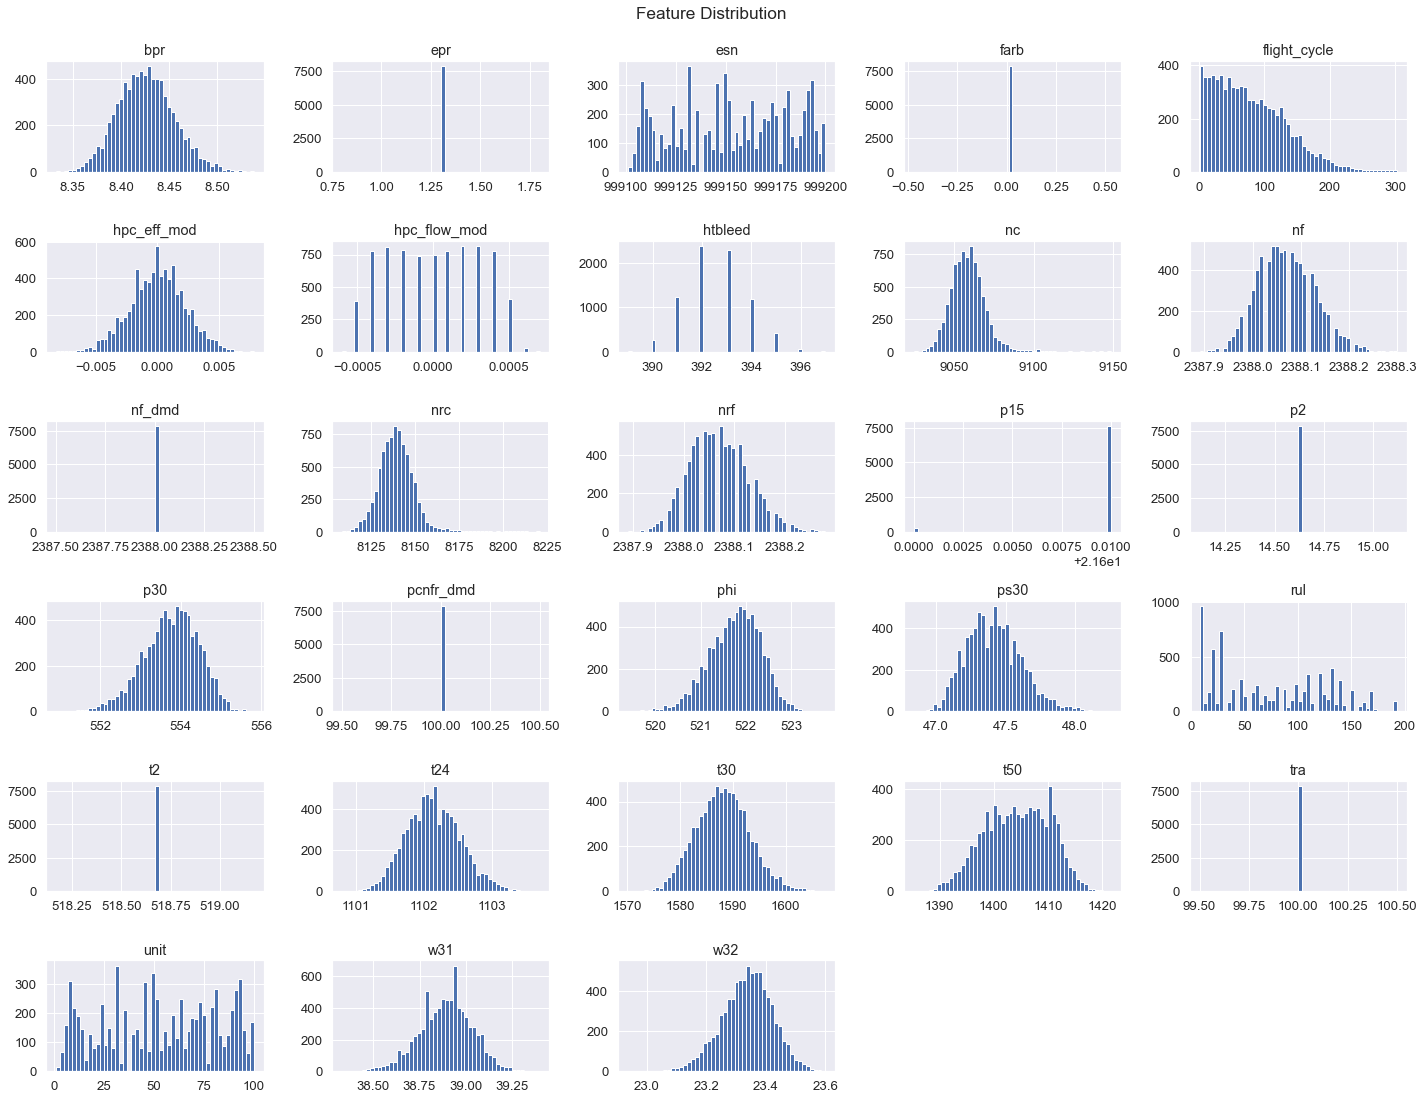

In [15]:
df.hist(bins=50, figsize=(20,15))
plt.suptitle('Feature Distribution', x=0.5, y=1.02, ha='center', fontsize='large')
plt.tight_layout()
plt.show()

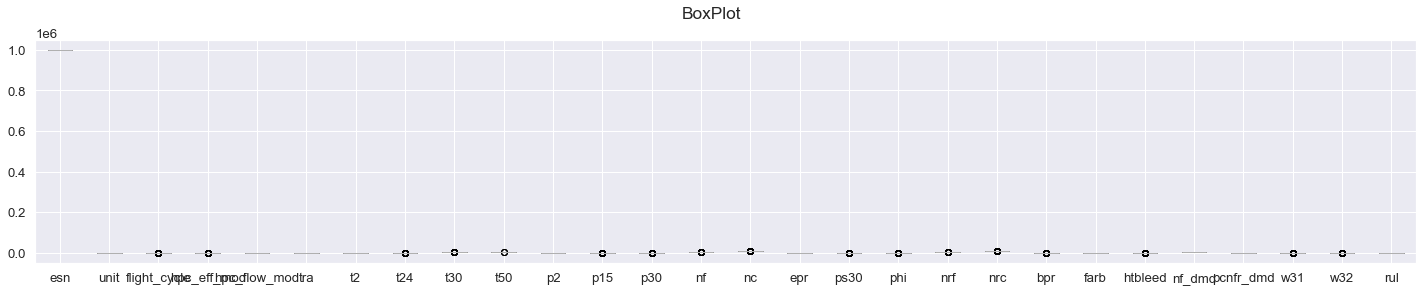

In [16]:
df.boxplot(figsize=(20,4))
plt.suptitle('BoxPlot', x=0.5, y=1.02, ha='center', fontsize='large')
plt.tight_layout()
plt.show()

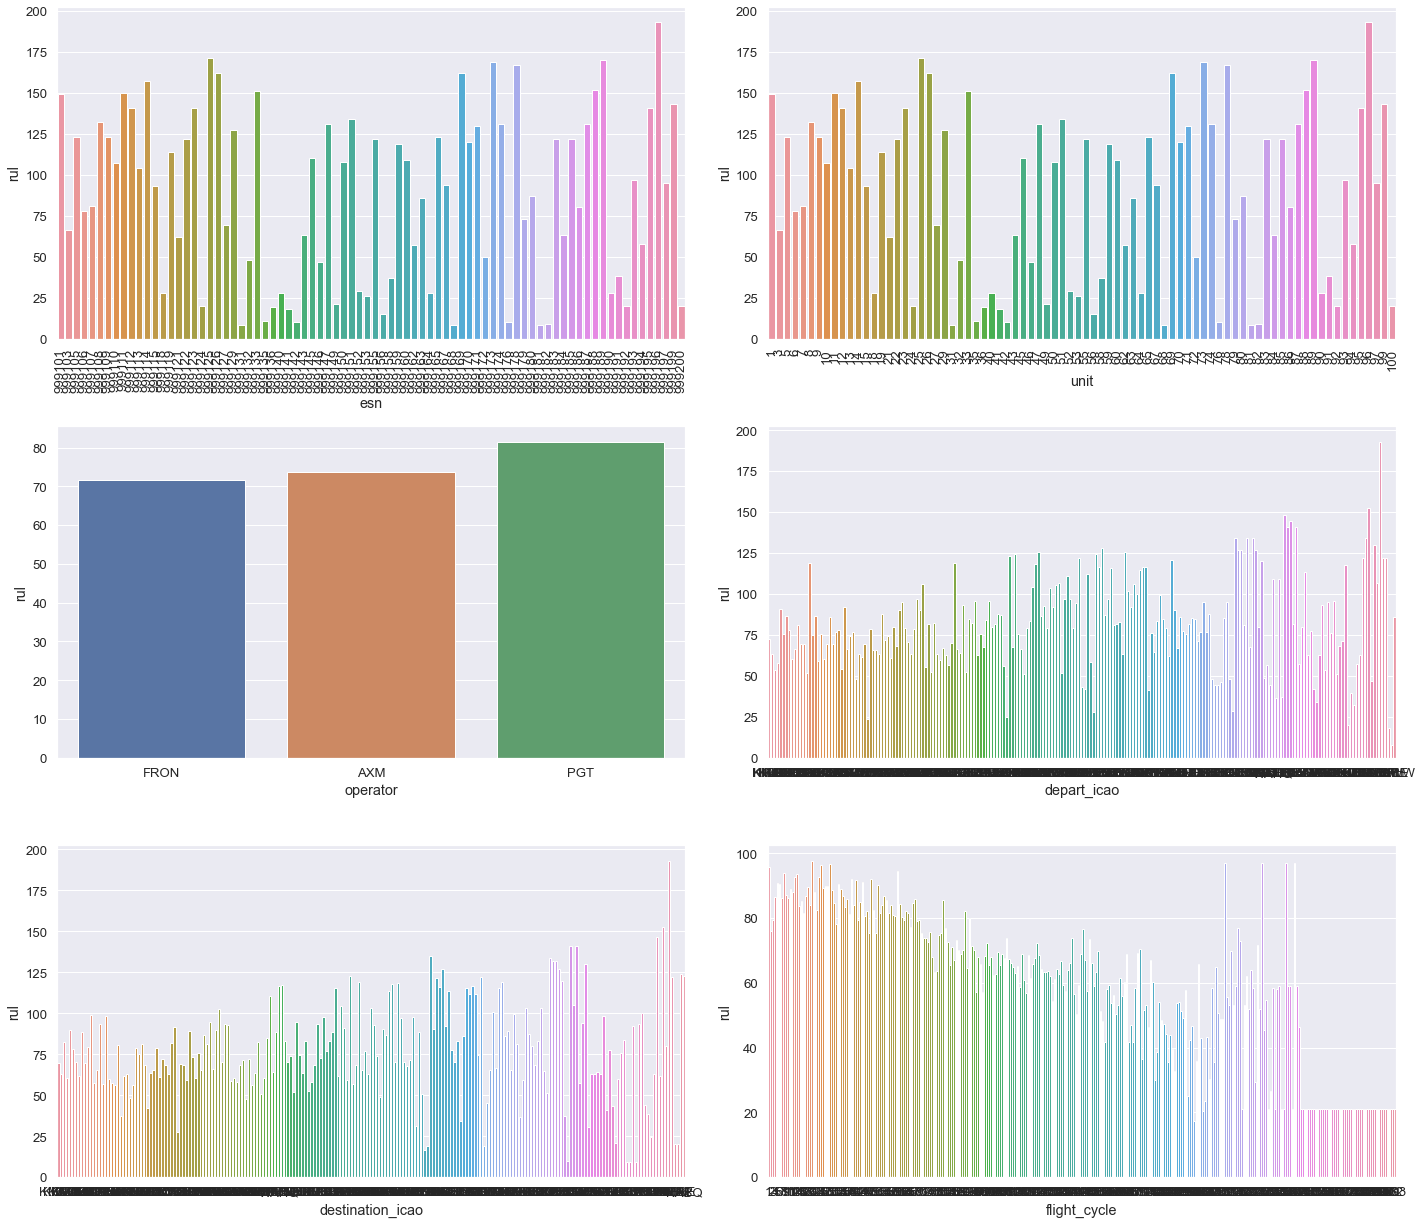

In [17]:
fig = plt.figure(figsize=(20,40))

plt.subplot(7,2,1)
plt.title("")
plt.xticks(rotation=90)
sns.barplot(x='esn',y='rul',data=df, ci=None)

plt.subplot(7,2,2)
plt.title("")
plt.xticks(rotation=90)
sns.barplot(x='unit',y='rul',data=df, ci=None)

plt.subplot(7,2,3)
plt.title("")
sns.barplot(x='operator',y='rul',data=df, ci=None)

plt.subplot(7,2,4)
plt.title("")
sns.barplot(x='depart_icao',y='rul',data=df, ci=None)

plt.subplot(7,2,5)
plt.title("")
sns.barplot(x='destination_icao',y='rul',data=df, ci=None)

plt.subplot(7,2,6)
plt.title("")
sns.barplot(x='flight_cycle',y='rul',data=df,ci=None)

plt.tight_layout()
plt.show()

### Bivariate Data Exploration

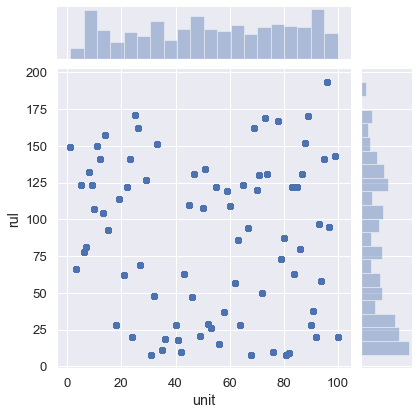

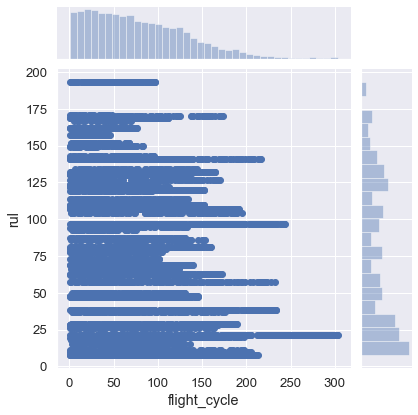

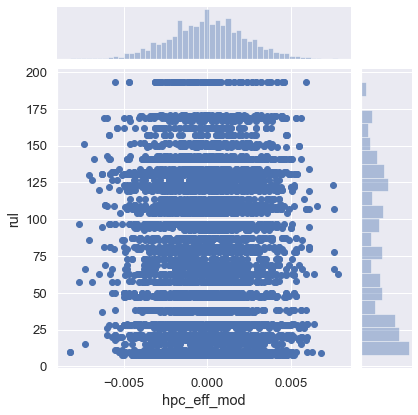

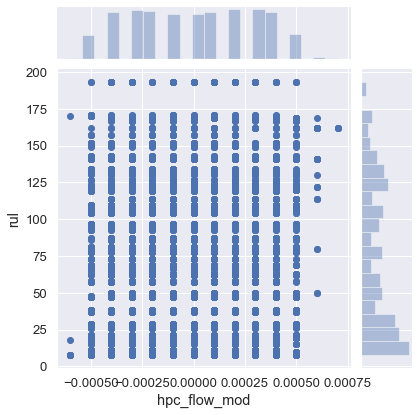

In [18]:
sns.jointplot(x='unit', y='rul',data=df, kind='scatter')

sns.jointplot(x='flight_cycle', y='rul',data=df, kind='scatter')

sns.jointplot(x='hpc_eff_mod', y='rul',data=df, kind='scatter')

sns.jointplot(x='hpc_flow_mod', y='rul',data=df, kind='scatter')

plt.show()

### Correlation

In [19]:
df.corr()

esn          unit  flight_cycle   hpc_eff_mod  hpc_flow_mod  tra            t2           t24           t30           t50            p2           p15           p30            nf            nc           epr          ps30           phi           nrf           nrc           bpr          farb       htbleed  nf_dmd  pcnfr_dmd           w31           w32           rul
esn           1.000000e+00  1.000000e+00  4.662282e-02 -2.641237e-02  1.821631e-02  NaN  7.484227e-13  9.432491e-02  7.952978e-02  1.144888e-01  7.444613e-13  1.550811e-02 -1.288369e-01  9.340305e-02  6.364508e-02  7.490046e-13  1.379833e-01 -1.141598e-01  1.068372e-01  3.709995e-02  1.145076e-01 -7.476745e-13  1.201176e-01     NaN        NaN -1.093032e-01 -1.057376e-01 -8.411122e-02
unit          1.000000e+00  1.000000e+00  4.662282e-02 -2.641237e-02  1.821631e-02  NaN -6.379500e-15  9.432491e-02  7.952978e-02  1.144888e-01 -5.501111e-15  1.550811e-02 -1.288369e-01  9.340305e-02  6.364508e-02  7.677200e-16  1.379833e-01 -1.141598e-01  1.068372e-01  3.709995e-02  1.145076e-01  4.523567e-15  1.201176e-01     NaN        NaN -1.093032e-01 -1.057376e-01 -8.411122e-02
flight_cycle  4.662282e-02  4.662282e-02  1.000000e+00 -7.069461e-03 -1.182806e-02  NaN  4.939114e-15  3.447851e-01  3.238912e-01  3.933623e-01 -1.199128e-15  7.906223e-02 -4.063343e-01  3.085726e-01  3.478762e-01 -2.940849e-15  4.484516e-01 -4.185135e-01  3.130091e-01  2.562700e-01  3.801506e-01 -1.382541e-16  3.622229e-01     NaN        NaN -3.747960e-01 -3.840635e-01 -2.484648e-01
hpc_eff_mod  -2.641237e-02 -2.641237e-02 -7.069461e-03  1.000000e+00 -2.386065e-02  NaN  9.748131e-18 -4.054677e-03 -1.010885e-02 -1.150500e-02  3.012142e-17 -1.522073e-02  1.111384e-02 -9.273152e-03 -9.813032e-03  2.920713e-16 -2.616762e-03  1.250779e-02 -2.640135e-03 -8.557919e-03 -1.123945e-02  8.938163e-19 -9.323081e-03     NaN        NaN  1.290747e-02  1.804984e-02  1.391128e-02
hpc_flow_mod  1.821631e-02  1.821631e-02 -1.182806e-02 -2.386065e-02  1.000000e+00  NaN -4.236261e-16 -3.735347e-02 -1.931092e-02 -2.607814e-02 -2.102000e-16 -3.431867e-03  2.707134e-02 -2.457831e-02  2.091743e-02 -9.046234e-16 -3.107954e-02  2.997459e-02 -3.278075e-02  2.967118e-02 -1.559758e-02 -3.157209e-16 -5.598902e-03     NaN        NaN  2.106277e-02  3.558589e-02  2.873865e-03
tra                    NaN           NaN           NaN           NaN           NaN  NaN           NaN           NaN           NaN           NaN           NaN           NaN           NaN           NaN           NaN           NaN           NaN           NaN           NaN           NaN           NaN           NaN           NaN     NaN        NaN           NaN           NaN           NaN
t2            7.484227e-13 -6.379500e-15  4.939114e-15  9.748131e-18 -4.236261e-16  NaN  1.000000e+00  5.813277e-12  4.550138e-13 -9.762339e-13  1.000000e+00  1.538353e-09  6.055570e-14  6.640087e-10 -1.724932e-12  1.000000e+00  8.428119e-13 -8.708393e-13  5.916148e-10 -3.920947e-12  1.107239e-12 -1.000000e+00  1.644753e-14     NaN        NaN -8.243496e-16  1.085447e-12  2.648203e-15
t24           9.432491e-02  9.432491e-02  3.447851e-01 -4.054677e-03 -3.735347e-02  NaN  5.813277e-12  1.000000e+00  4.057623e-01  5.312692e-01  5.813179e-12  1.395417e-01 -5.338622e-01  5.348438e-01  1.971128e-02  5.813256e-12  5.750172e-01 -5.708872e-01  5.429218e-01 -1.004064e-01  5.113322e-01 -5.813342e-12  4.393876e-01     NaN        NaN -4.791198e-01 -4.750567e-01 -1.540636e-01
t30           7.952978e-02  7.952978e-02  3.238912e-01 -1.010885e-02 -1.931092e-02  NaN  4.550138e-13  4.057623e-01  1.000000e+00  4.632932e-01  4.552449e-13  1.020371e-01 -4.918263e-01  4.704796e-01  6.807751e-02  4.551877e-13  5.161374e-01 -5.011606e-01  4.581317e-01 -3.598262e-02  4.465199e-01 -4.546480e-13  3.979014e-01     NaN        NaN -4.343413e-01 -4.213399e-01 -1.447240e-01
t50           1.144888e-01  1.144888e-01  3.933623e-01 -1.150500e-02 -2.607814e-02  NaN -9.762339e-13  5.312692e-01  4.632932e-01  1.000000e+00 -9.760225

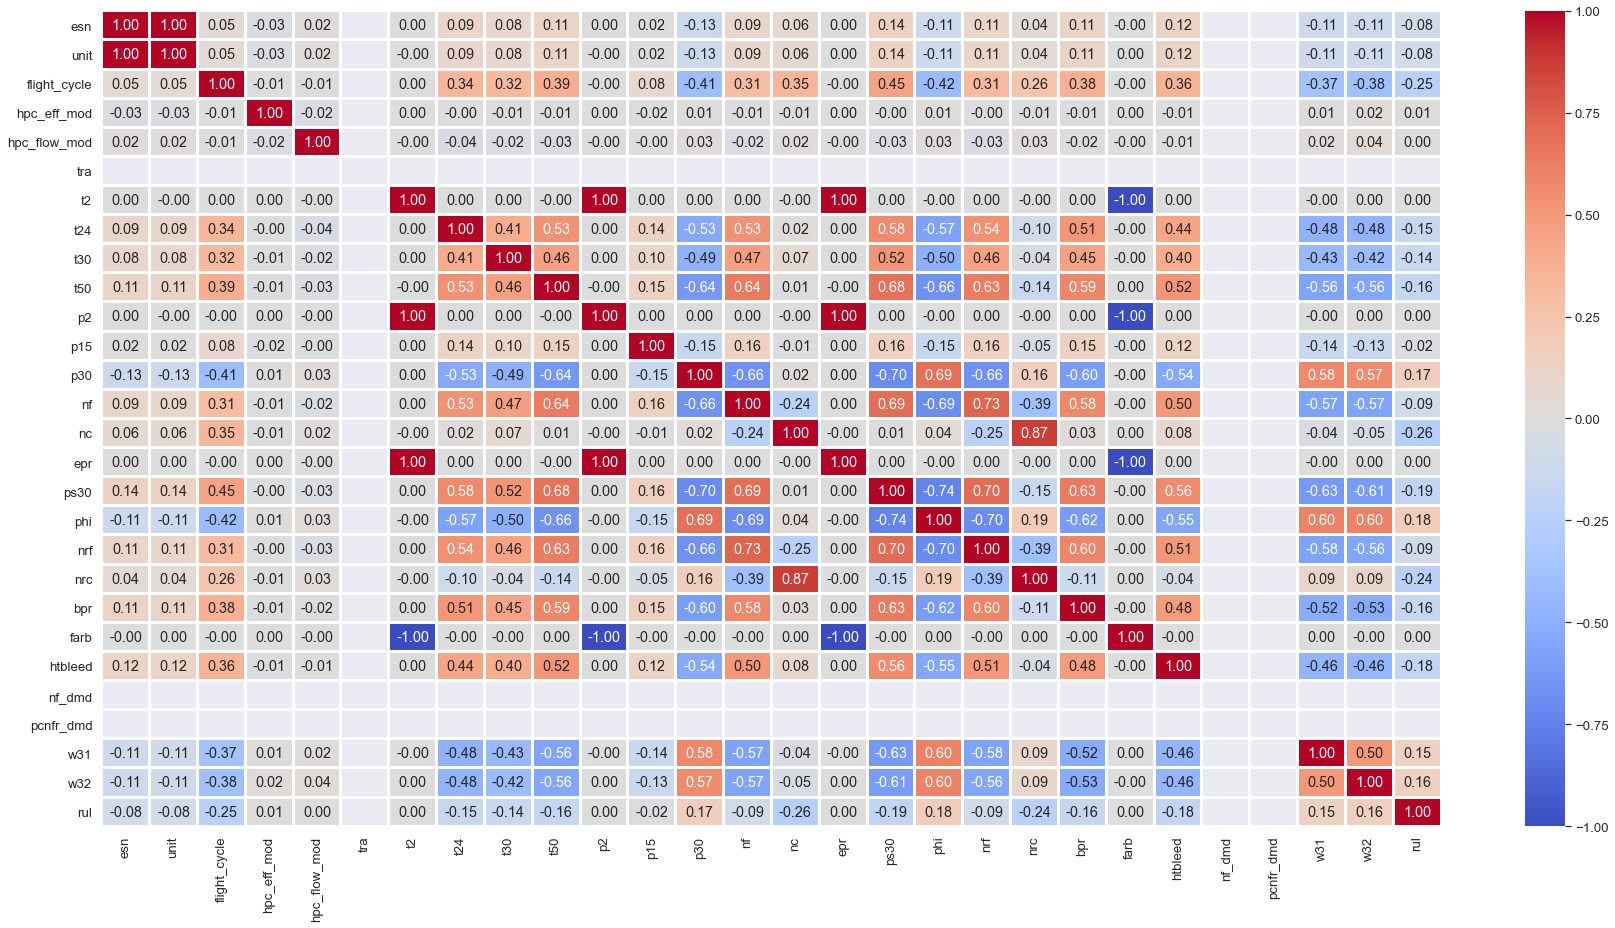

In [20]:
plt.figure(figsize=(30,15))
sns.heatmap(df.corr(),cmap="coolwarm",annot=True,fmt='.2f',linewidths=2)
plt.show()

### Pairplots

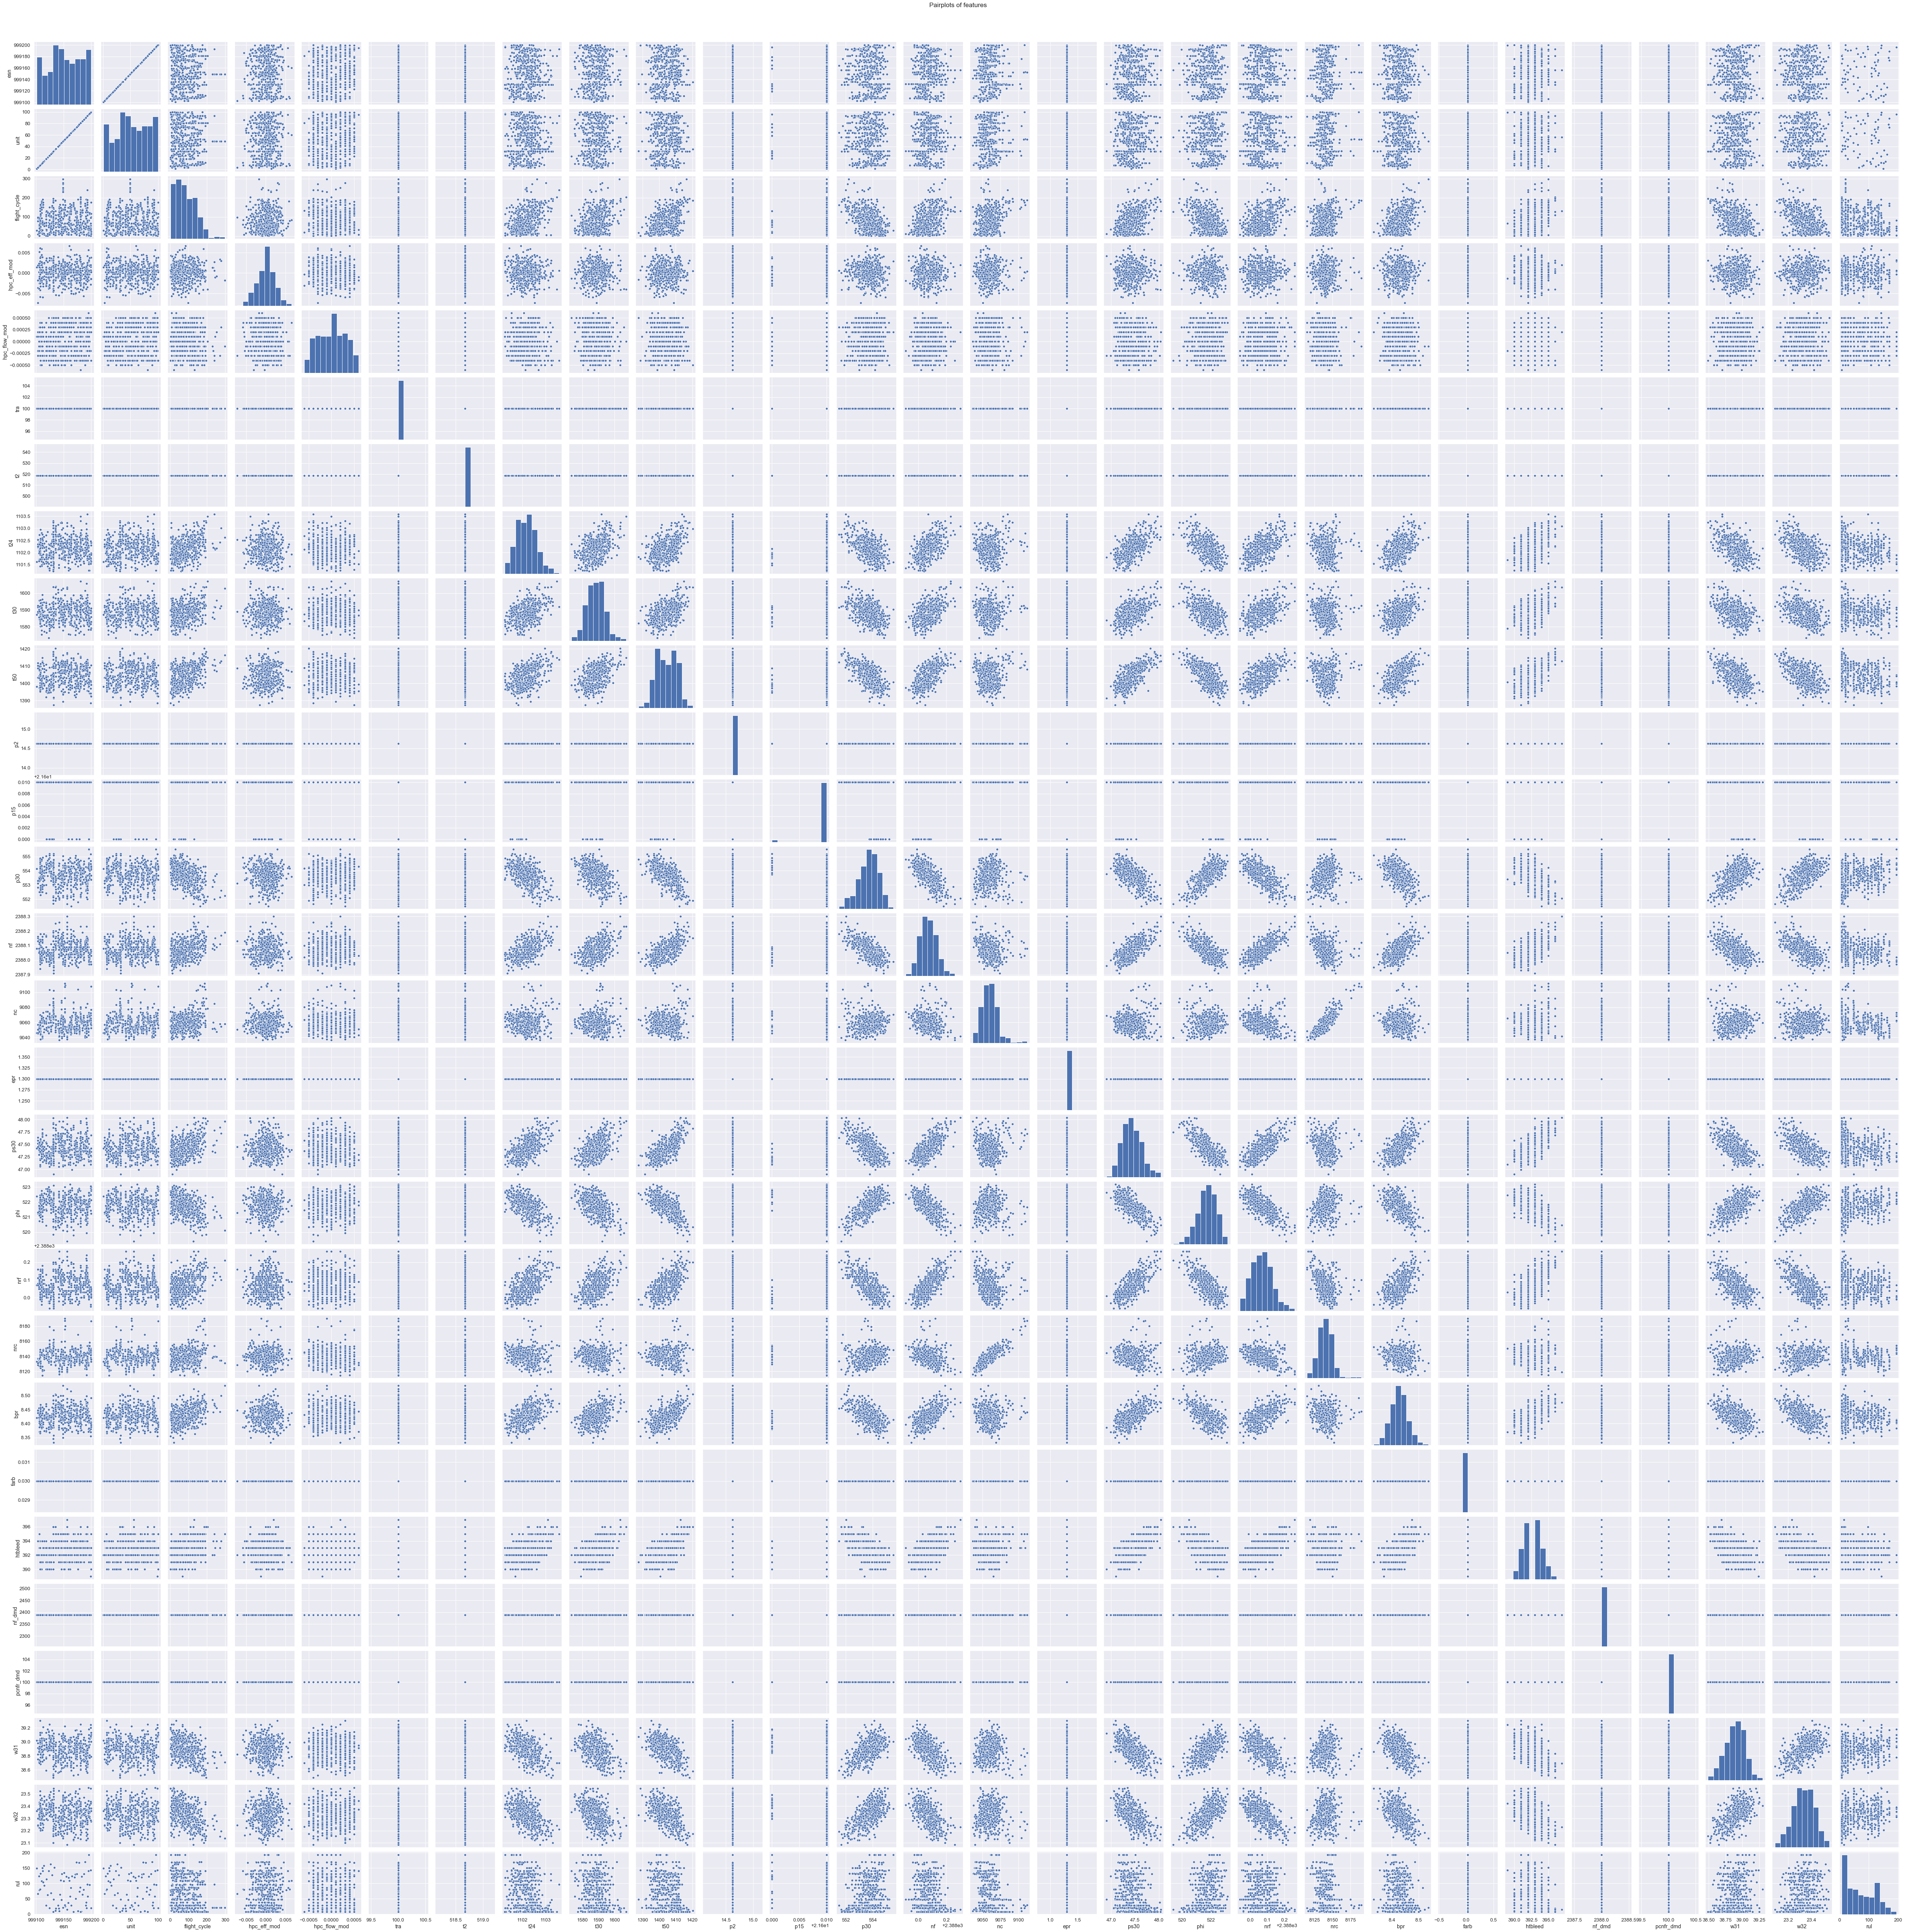

In [21]:
sns.pairplot(df.sample(500))
plt.suptitle('Pairplots of features', x=0.5, y=1.02, ha='center', fontsize='large')
plt.show()

### Data Preprocessing

### Drop unwanted features

In [22]:
df.columns

Index(['dataset', 'esn', 'unit', 'flight_cycle', 'datetime', 'operator', 'depart_icao', 'destination_icao', 'hpc_eff_mod', 'hpc_flow_mod', 'tra', 't2', 't24', 't30', 't50', 'p2', 'p15', 'p30', 'nf', 'nc', 'epr', 'ps30', 'phi', 'nrf', 'nrc', 'bpr', 'farb', 'htbleed', 'nf_dmd', 'pcnfr_dmd', 'w31', 'w32', 'rul'], dtype='object')

In [23]:
df.drop(['dataset', 'esn', 'datetime', 'operator', 'depart_icao', 'destination_icao'],axis=1,inplace=True)

In [24]:
df

unit  flight_cycle  hpc_eff_mod  hpc_flow_mod  tra      t2      t24      t30      t50     p2    p15     p30       nf       nc  epr   ps30     phi      nrf      nrc     bpr  farb  htbleed  nf_dmd  pcnfr_dmd    w31      w32  rul
0       59            15      -0.0019        0.0002  100  518.67  1101.59  1581.43  1397.66  14.62  21.61  553.76  2387.98  9053.86  1.3  47.15  521.75  2388.00  8141.38  8.3718  0.03      390    2388        100  39.07  23.3881  119
1       59             1      -0.0008       -0.0004  100  518.67  1101.92  1589.29  1395.20  14.62  21.61  554.74  2387.96  9050.56  1.3  47.44  522.52  2388.02  8139.38  8.3801  0.03      390    2388        100  39.14  23.3486  119
2       59            55       0.0008       -0.0001  100  518.67  1101.80  1577.44  1396.72  14.62  21.61  554.42  2387.97  9052.88  1.3  47.20  522.58  2388.04  8134.88  8.3841  0.03      393    2388        100  39.06  23.3695  119
3       59             6      -0.0009       -0.0002  100  518.67  1101.40  1579.85  1397.03  14.62  21.61  554.92  2388.00  9060.03  1.3  47.12  522.20  2388.00  8134.46  8.4105  0.03      391    2388        100  38.94  23.3968  119
4       59            66       0.0003        0.0001  100  518.67  1101.92  1585.21  1406.96  14.62  21.61  554.56  2388.05  9061.70  1.3  47.12  522.33  2388.03  8134.46  8.4097  0.03      393    2388        100  38.98  23.4150  119
...    ...           ...          ...           ...  ...     ...      ...      ...      ...    ...    ...     ...      ...      ...  ...    ...     ...      ...      ...     ...   ...      ...     ...        ...    ...      ...  ...
7858     1            29       0.0014        0.0001  100  518.67  1101.62  1587.15  1398.11  14.62  21.61  554.15  2388.08  9046.11  1.3  47.42  522.39  2388.07  8133.13  8.4212  0.03      392    2388        100  39.02  23.3621  149
7859     1            24      -0.0006       -0.0001  100  518.67  1101.99  1594.29  1400.15  14.62  21.61  553.27  2388.07  9043.32  1.3  47.29  522.06  2388.12  8130.70  8.4074  0.03      393    2388        100  38.94  23.3971  149
7860     1             4       0.0042        0.0000  100  518.67  1102.11  1584.12  1406.42  14.62  21.61  554.07  2388.03  9045.29  1.3  47.28  521.38  2388.05  8132.90  8.3917  0.03      391    2388        100  39.00  23.3737  149
7861     1            31      -0.0006        0.0004  100  518.67  1102.25  1581.22  1398.91  14.62  21.61  554.42  2388.08  9056.40  1.3  47.23  521.79  2388.06  8130.11  8.4024  0.03      393    2388        100  38.81  23.3552  149
7862     1            11       0.0007       -0.0004  100  518.67  1101.71  1581.03  1403.83  14.62  21.61  554.69  2388.04  9051.67  1.3  47.23  521.95  2388.06  8132.38  8.3919  0.03      391    2388        100  39.06  23.3609  149

[7863 rows x 27 columns]

### Treat Missing Values

In [25]:
df.isnull().sum()

unit            0
flight_cycle    0
hpc_eff_mod     0
hpc_flow_mod    0
tra             0
t2              0
t24             0
t30             0
t50             0
p2              0
p15             0
p30             0
nf              0
nc              0
epr             0
ps30            0
phi             0
nrf             0
nrc             0
bpr             0
farb            0
htbleed         0
nf_dmd          0
pcnfr_dmd       0
w31             0
w32             0
rul             0
dtype: int64

### Treat Duplicate Values

In [26]:
df.duplicated(keep='first').sum()

1238

In [27]:
df[df.duplicated(keep=False)] #Check duplicate values

unit  flight_cycle  hpc_eff_mod  hpc_flow_mod  tra      t2      t24      t30       t50     p2    p15     p30       nf       nc  epr   ps30     phi      nrf      nrc     bpr  farb  htbleed  nf_dmd  pcnfr_dmd    w31      w32  rul
138     31           100       0.0007        0.0004  100  518.67  1102.65  1581.48  1395.890  14.62  21.61  554.58  2388.03  9067.04  1.3  47.50  521.81  2388.03  8150.13  8.4467  0.03      393    2388        100  38.88  23.4060    8
139     31            94       0.0028       -0.0002  100  518.67  1101.48  1587.82  1406.170  14.62  21.61  553.80  2388.03  9071.09  1.3  47.57  521.58  2388.02  8149.83  8.3995  0.03      392    2388        100  38.90  23.3484    8
140     31            54       0.0008        0.0001  100  518.67  1102.04  1594.56  1399.040  14.62  21.61  554.32  2388.01  9074.51  1.3  47.31  521.64  2388.06  8147.86  8.3937  0.03      393    2388        100  38.89  23.3696    8
144     31           118      -0.0023        0.0005  100  518.67  1102.54  1592.12  1410.270  14.62  21.61  553.03  2388.09  9076.24  1.3  47.55  521.50  2388.12  8141.29  8.4208  0.03      393    2388        100  38.93  23.2933    8
145     31           101       0.0033        0.0004  100  518.67  1102.24  1595.09  1403.620  14.62  21.61  554.16  2388.07  9077.60  1.3  47.44  521.93  2387.96  8152.98  8.4204  0.03      392    2388        100  38.86  23.3907    8
...    ...           ...          ...           ...  ...     ...      ...      ...       ...    ...    ...     ...      ...      ...  ...    ...     ...      ...      ...     ...   ...      ...     ...        ...    ...      ...  ...
7268    14            14       0.0019       -0.0001  100  518.67  1102.16  1588.04  1409.690  14.62  21.61  553.97  2388.12  9032.93  1.3  47.47  521.12  2388.12  8121.04  8.4402  0.03      394    2388        100  38.76  23.4023  157
7269    14            25       0.0047        0.0004  100  518.67  1102.23  1586.48  1403.990  14.62  21.61  553.32  2388.16  9040.89  1.3  47.62  521.71  2388.17  8115.83  8.4079  0.03      392    2388        100  38.85  23.2271  157
7270    14             7      -0.0007       -0.0005  100  518.67  1102.63  1588.25  1409.930  14.62  21.61  553.62  2388.20  9035.10  1.3  47.52  520.54  2388.18  8114.73  8.4362  0.03      394    2388        100  39.00  23.1876  157
7271    14            25       0.0047        0.0004  100  518.67  1102.23  1586.48  1403.990  14.62  21.61  553.32  2388.16  9040.89  1.3  47.62  521.71  2388.17  8115.83  8.4079  0.03      392    2388        100  38.85  23.2271  157
7276    14            21      -0.0026        0.0004  100  518.67  1102.29  1594.25  1412.005  14.62  21.61  553.62  2388.16  9040.33  1.3  47.49  520.94  2388.09  8120.80  8.4490  0.03      393    2388        100  38.98  23.3165  157

[2476 rows x 27 columns]

### Treat Outliers

In [28]:
df.describe()

unit  flight_cycle  hpc_eff_mod  hpc_flow_mod     tra            t2          t24          t30          t50            p2          p15          p30           nf           nc           epr         ps30          phi          nrf          nrc          bpr          farb      htbleed  nf_dmd  pcnfr_dmd          w31          w32          rul
count  7863.000000   7863.000000  7863.000000   7863.000000  7863.0  7.863000e+03  7863.000000  7863.000000  7863.000000  7.863000e+03  7863.000000  7863.000000  7863.000000  7863.000000  7.863000e+03  7863.000000  7863.000000  7863.000000  7863.000000  7863.000000  7.863000e+03  7863.000000  7863.0     7863.0  7863.000000  7863.000000  7863.000000
mean     53.244563     78.918352     0.000005      0.000005   100.0  5.186700e+02  1102.144751  1588.146187  1404.281850  1.462000e+01    21.609691   553.755804  2388.070207  9058.730584  1.300000e+00    47.416045   521.750237  2388.070242  8139.244662     8.425900  3.000000e-02   392.564034  2388.0      100.0    38.891049    23.335624    74.818390
std      28.643980     55.198817     0.002225      0.000296     0.0  5.059386e-11     0.401772     5.085923     5.984049  1.350117e-12     0.001731     0.690370     0.058583    11.310730  4.174704e-14     0.198469     0.571852     0.057399    10.054097     0.029418  1.040900e-15     1.237890     0.0        0.0     0.143092     0.084965    51.138268
min       1.000000      1.000000    -0.008200     -0.000600   100.0  5.186700e+02  1100.800000  1570.120000  1385.210000  1.462000e+01    21.600000   550.910000  2387.890000  9024.530000  1.300000e+00    46.840000   519.390000  2387.890000  8108.500000     8.332800  3.000000e-02   389.000000  2388.0      100.0    38.330000    22.935400     8.000000
25%      29.000000     34.000000    -0.001500     -0.000300   100.0  5.186700e+02  1101.860000  1584.600000  1399.810000  1.462000e+01    21.610000   553.310000  2388.030000  9051.460000  1.300000e+00    47.270000   521.370000  2388.030000  8132.900000     8.405200  3.000000e-02   392.000000  2388.0      100.0    38.800000    23.280800    28.000000
50%      53.000000     70.000000     0.000000      0.000000   100.0  5.186700e+02  1102.130000  1588.060000  1404.450000  1.462000e+01    21.610000   553.800000  2388.070000  9058.040000  1.300000e+00    47.400000   521.790000  2388.070000  8138.850000     8.424900  3.000000e-02   393.000000  2388.0      100.0    38.900000    23.339500    69.000000
75%      79.000000    115.000000     0.001500      0.000300   100.0  5.186700e+02  1102.415000  1591.520000  1409.125000  1.462000e+01    21.610000   554.250000  2388.110000  9064.675000  1.300000e+00    47.540000   522.160000  2388.110000  8144.895000     8.444700  3.000000e-02   393.000000  2388.0      100.0    38.990000    23.393400   120.000000
max     100.000000    303.000000     0.007800      0.000700   100.0  5.186700e+02  1103.700000  1607.550000  1421.680000  1.462000e+01    21.610000   555.810000  2388.300000  9148.850000  1.300000e+00    48.260000   523.760000  2388.280000  8220.480000     8.537500  3.000000e-02   397.000000  2388.0      100.0    39.400000    23.600300   193.000000

### Perform One-Hot Encoding

### Create and save processed dataset

In [29]:
#df.to_csv("train.csv",index=False)

In [30]:
df.shape

(7863, 27)

### Train Test Split

In [31]:
df = pd.read_csv("train.csv")

In [32]:
df

unit  flight_cycle  hpc_eff_mod  hpc_flow_mod  tra      t2      t24      t30      t50     p2    p15     p30       nf       nc  epr   ps30     phi      nrf      nrc     bpr  farb  htbleed  nf_dmd  pcnfr_dmd    w31      w32  rul
0       59            15      -0.0019        0.0002  100  518.67  1101.59  1581.43  1397.66  14.62  21.61  553.76  2387.98  9053.86  1.3  47.15  521.75  2388.00  8141.38  8.3718  0.03      390    2388        100  39.07  23.3881  119
1       59             1      -0.0008       -0.0004  100  518.67  1101.92  1589.29  1395.20  14.62  21.61  554.74  2387.96  9050.56  1.3  47.44  522.52  2388.02  8139.38  8.3801  0.03      390    2388        100  39.14  23.3486  119
2       59            55       0.0008       -0.0001  100  518.67  1101.80  1577.44  1396.72  14.62  21.61  554.42  2387.97  9052.88  1.3  47.20  522.58  2388.04  8134.88  8.3841  0.03      393    2388        100  39.06  23.3695  119
3       59             6      -0.0009       -0.0002  100  518.67  1101.40  1579.85  1397.03  14.62  21.61  554.92  2388.00  9060.03  1.3  47.12  522.20  2388.00  8134.46  8.4105  0.03      391    2388        100  38.94  23.3968  119
4       59            66       0.0003        0.0001  100  518.67  1101.92  1585.21  1406.96  14.62  21.61  554.56  2388.05  9061.70  1.3  47.12  522.33  2388.03  8134.46  8.4097  0.03      393    2388        100  38.98  23.4150  119
...    ...           ...          ...           ...  ...     ...      ...      ...      ...    ...    ...     ...      ...      ...  ...    ...     ...      ...      ...     ...   ...      ...     ...        ...    ...      ...  ...
7858     1            29       0.0014        0.0001  100  518.67  1101.62  1587.15  1398.11  14.62  21.61  554.15  2388.08  9046.11  1.3  47.42  522.39  2388.07  8133.13  8.4212  0.03      392    2388        100  39.02  23.3621  149
7859     1            24      -0.0006       -0.0001  100  518.67  1101.99  1594.29  1400.15  14.62  21.61  553.27  2388.07  9043.32  1.3  47.29  522.06  2388.12  8130.70  8.4074  0.03      393    2388        100  38.94  23.3971  149
7860     1             4       0.0042        0.0000  100  518.67  1102.11  1584.12  1406.42  14.62  21.61  554.07  2388.03  9045.29  1.3  47.28  521.38  2388.05  8132.90  8.3917  0.03      391    2388        100  39.00  23.3737  149
7861     1            31      -0.0006        0.0004  100  518.67  1102.25  1581.22  1398.91  14.62  21.61  554.42  2388.08  9056.40  1.3  47.23  521.79  2388.06  8130.11  8.4024  0.03      393    2388        100  38.81  23.3552  149
7862     1            11       0.0007       -0.0004  100  518.67  1101.71  1581.03  1403.83  14.62  21.61  554.69  2388.04  9051.67  1.3  47.23  521.95  2388.06  8132.38  8.3919  0.03      391    2388        100  39.06  23.3609  149

[7863 rows x 27 columns]

In [33]:
X = df.iloc[:,0:26]
y = df.iloc[:,26]

In [34]:
X.values, y.values

(array([[ 59.    ,  15.    ,  -0.0019, ..., 100.    ,  39.07  ,  23.3881],
        [ 59.    ,   1.    ,  -0.0008, ..., 100.    ,  39.14  ,  23.3486],
        [ 59.    ,  55.    ,   0.0008, ..., 100.    ,  39.06  ,  23.3695],
        ...,
        [  1.    ,   4.    ,   0.0042, ..., 100.    ,  39.    ,  23.3737],
        [  1.    ,  31.    ,  -0.0006, ..., 100.    ,  38.81  ,  23.3552],
        [  1.    ,  11.    ,   0.0007, ..., 100.    ,  39.06  ,  23.3609]]),
 array([119, 119, 119, ..., 149, 149, 149], dtype=int64))

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [36]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6290, 26), (1573, 26), (6290,), (1573,))

In [37]:
X_train[0:5]

unit  flight_cycle  hpc_eff_mod  hpc_flow_mod  tra      t2      t24      t30       t50     p2    p15     p30       nf       nc  epr   ps30     phi      nrf      nrc     bpr  farb  htbleed  nf_dmd  pcnfr_dmd    w31      w32
7156     6            81       0.0046        0.0003  100  518.67  1102.26  1577.57  1406.420  14.62  21.61  553.43  2388.09  9059.78  1.3  47.47  521.51  2388.09  8134.30  8.4234  0.03      393    2388        100  38.93  23.4005
3490    23           119       0.0016       -0.0004  100  518.67  1102.26  1581.73  1395.800  14.62  21.61  553.98  2388.04  9046.53  1.3  47.19  522.00  2388.05  8128.95  8.4147  0.03      391    2388        100  38.81  23.3048
4832    49           275      -0.0035        0.0001  100  518.67  1102.63  1593.65  1412.155  14.62  21.61  552.46  2388.20  9051.39  1.3  47.67  521.09  2388.22  8129.83  8.4692  0.03      394    2388        100  38.76  23.2642
6730    56            84      -0.0005       -0.0001  100  518.67  1102.42  1596.81  1411.265  14.62  21.61  553.45  2388.22  9042.49  1.3  47.59  520.82  2388.18  8123.36  8.4917  0.03      395    2388        100  38.70  23.3003
6777    56            69       0.0010        0.0001  100  518.67  1102.51  1592.73  1413.555  14.62  21.61  553.06  2388.15  9045.47  1.3  47.74  520.89  2388.15  8125.09  8.4402  0.03      394    2388        100  38.95  23.2476

### Feature Selection

### Using SelectKBest

In [38]:
X_new = SelectKBest(f_regression, k=10).fit_transform(X_train,y_train)

In [39]:
X_new[0:5]

array([[  81.    , 1406.42  ,  553.43  , 9059.78  ,   47.47  ,  521.51  ,
        8134.3   ,    8.4234,  393.    ,   23.4005],
       [ 119.    , 1395.8   ,  553.98  , 9046.53  ,   47.19  ,  522.    ,
        8128.95  ,    8.4147,  391.    ,   23.3048],
       [ 275.    , 1412.155 ,  552.46  , 9051.39  ,   47.67  ,  521.09  ,
        8129.83  ,    8.4692,  394.    ,   23.2642],
       [  84.    , 1411.265 ,  553.45  , 9042.49  ,   47.59  ,  520.82  ,
        8123.36  ,    8.4917,  395.    ,   23.3003],
       [  69.    , 1413.555 ,  553.06  , 9045.47  ,   47.74  ,  520.89  ,
        8125.09  ,    8.4402,  394.    ,   23.2476]])

**SelectKBest selects flight_cycle,t50,p30,nc,ps30,phi,nrc,bpr,htbleed,w32**

### Univariate Feature Selection

In [40]:
select_feature = SelectKBest(chi2, k=10).fit(X_train,y_train)

ValueError: Input X must be non-negative.

In [ ]:
select_feature.scores

### Recursive Feature Elimination

In [41]:
rfe = RFE(estimator=XGBRegressor(),n_features_to_select=10,verbose=1, step=1)

In [42]:
rfe.fit(X_train,y_train)

Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.


RFE(estimator=XGBRegressor(base_score=None, booster=None,
                           colsample_bylevel=None, colsample_bynode=None,
                           colsample_bytree=None, gamma=None, gpu_id=None,
                           importance_type='gain', interaction_constraints=None,
                           learning_rate=None, max_delta_step=None,
                           max_depth=None, min_child_weight=None, missing=nan,
                           monotone_constraints=None, n_estimators=100,
                           n_jobs=None, num_parallel_tree=None,
                           random_state=None, reg_alpha=None, reg_lambda=None,
                           scale_pos_weight=None, subsample=None,
                           tree_method=None, validate_parameters=None,
                           verbosity=None),
    n_features_to_select=10, verbose=1)

In [43]:
selected_rfe_features = pd.DataFrame({'Feature':list(X_train.columns),'Ranking':rfe.ranking_}                                               )

In [44]:
selected_rfe_features

Feature  Ranking
0           unit        1
1   flight_cycle        1
2    hpc_eff_mod       10
3   hpc_flow_mod        8
4            tra       13
5             t2       12
6            t24        7
7            t30        5
8            t50        1
9             p2       17
10           p15        9
11           p30        2
12            nf        1
13            nc        1
14           epr       11
15          ps30        1
16           phi        1
17           nrf        1
18           nrc        1
19           bpr        4
20          farb       16
21       htbleed        3
22        nf_dmd       14
23     pcnfr_dmd       15
24           w31        1
25           w32        6

### Recursive Feature Elimnation with Cross Validation

In [45]:
rfecv = RFECV(estimator=XGBRegressor(), cv=5,scoring="neg_mean_squared_error",verbose=1, step=1)

In [46]:
rfecv.fit(X_train,y_train)

Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.


RFECV(cv=5,
      estimator=XGBRegressor(base_score=None, booster=None,
                             colsample_bylevel=None, colsample_bynode=None,
                             colsample_bytree=None, gamma=None, gpu_id=None,
                             importance_type='gain',
                             interaction_constraints=None, learning_rate=None,
                             max_delta_step=None, max_depth=None,
                             min_child_weight=None, missing=nan,
                             monotone_constraints=None, n_estimators=100,
                             n_jobs=None, num_parallel_tree=None,
                             random_state=None, reg_alpha=None, reg_lambda=None,
                             scale_pos_weight=None, subsample=None,
                             tree_method=None, validate_parameters=None,
                             verbosity=None),
      scoring='neg_mean_squared_error', verbose=1)

In [47]:
print("Optimal no of features:", rfecv.n_features_)

Optimal no of features: 1


In [48]:
print("Best features:", rfecv.support_)

Best features: [ True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]


### Drop unwanted features

In [49]:
df.columns

Index(['unit', 'flight_cycle', 'hpc_eff_mod', 'hpc_flow_mod', 'tra', 't2', 't24', 't30', 't50', 'p2', 'p15', 'p30', 'nf', 'nc', 'epr', 'ps30', 'phi', 'nrf', 'nrc', 'bpr', 'farb', 'htbleed', 'nf_dmd', 'pcnfr_dmd', 'w31', 'w32', 'rul'], dtype='object')

In [50]:
df.drop(['hpc_eff_mod', 'hpc_flow_mod','tra', 't2', 't24', 't30','p2', 'p15', 'p30',
         'epr', 'bpr', 'farb', 'htbleed', 'nf_dmd', 'pcnfr_dmd','w32'],axis=1,inplace=True)

In [51]:
df

unit  flight_cycle      t50       nf       nc   ps30     phi      nrf      nrc    w31  rul
0       59            15  1397.66  2387.98  9053.86  47.15  521.75  2388.00  8141.38  39.07  119
1       59             1  1395.20  2387.96  9050.56  47.44  522.52  2388.02  8139.38  39.14  119
2       59            55  1396.72  2387.97  9052.88  47.20  522.58  2388.04  8134.88  39.06  119
3       59             6  1397.03  2388.00  9060.03  47.12  522.20  2388.00  8134.46  38.94  119
4       59            66  1406.96  2388.05  9061.70  47.12  522.33  2388.03  8134.46  38.98  119
...    ...           ...      ...      ...      ...    ...     ...      ...      ...    ...  ...
7858     1            29  1398.11  2388.08  9046.11  47.42  522.39  2388.07  8133.13  39.02  149
7859     1            24  1400.15  2388.07  9043.32  47.29  522.06  2388.12  8130.70  38.94  149
7860     1             4  1406.42  2388.03  9045.29  47.28  521.38  2388.05  8132.90  39.00  149
7861     1            31  1398.91  2388.08  9056.40  47.23  521.79  2388.06  8130.11  38.81  149
7862     1            11  1403.83  2388.04  9051.67  47.23  521.95  2388.06  8132.38  39.06  149

[7863 rows x 11 columns]

In [52]:
X = df.iloc[:,0:10]
y = df.iloc[:,10]

In [53]:
X.values, y.values

(array([[  59.  ,   15.  , 1397.66, ..., 2388.  , 8141.38,   39.07],
        [  59.  ,    1.  , 1395.2 , ..., 2388.02, 8139.38,   39.14],
        [  59.  ,   55.  , 1396.72, ..., 2388.04, 8134.88,   39.06],
        ...,
        [   1.  ,    4.  , 1406.42, ..., 2388.05, 8132.9 ,   39.  ],
        [   1.  ,   31.  , 1398.91, ..., 2388.06, 8130.11,   38.81],
        [   1.  ,   11.  , 1403.83, ..., 2388.06, 8132.38,   39.06]]),
 array([119, 119, 119, ..., 149, 149, 149], dtype=int64))

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [55]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6290, 10), (1573, 10), (6290,), (1573,))

### Feature Scaling

In [56]:
X_train

unit  flight_cycle       t50       nf       nc   ps30     phi      nrf      nrc    w31
7156     6            81  1406.420  2388.09  9059.78  47.47  521.51  2388.09  8134.30  38.93
3490    23           119  1395.800  2388.04  9046.53  47.19  522.00  2388.05  8128.95  38.81
4832    49           275  1412.155  2388.20  9051.39  47.67  521.09  2388.22  8129.83  38.76
6730    56            84  1411.265  2388.22  9042.49  47.59  520.82  2388.18  8123.36  38.70
6777    56            69  1413.555  2388.15  9045.47  47.74  520.89  2388.15  8125.09  38.95
...    ...           ...       ...      ...      ...    ...     ...      ...      ...    ...
4931    49           120  1399.340  2387.99  9064.82  47.19  522.41  2388.04  8141.39  39.11
3264    83            36  1403.810  2388.03  9061.01  47.41  521.78  2388.09  8137.70  38.91
1653    92            26  1409.410  2388.14  9036.46  47.58  521.06  2388.14  8124.91  38.93
2607    18            23  1394.940  2388.07  9065.30  47.32  521.95  2387.94  8142.82  39.06
2732    52           101  1397.440  2388.01  9067.78  47.29  522.48  2388.03  8140.06  38.90

[6290 rows x 10 columns]

In [57]:
scaler = StandardScaler()

In [58]:
X_train_scaled = scaler.fit_transform(X_train)

In [59]:
X_test_scaled = scaler.transform(X_test)

In [60]:
X_train_scaled

array([[-1.6464512 ,  0.0494654 ,  0.36407748, ...,  0.34578746,
        -0.48792375,  0.27396144],
       [-1.05488038,  0.74063918, -1.40744505, ..., -0.3539642 ,
        -1.0198486 , -0.56697428],
       [-0.150125  ,  3.57808946,  1.320733  , ...,  2.61998035,
        -0.93235442, -0.91736416],
       ...,
       [ 1.34620121, -0.95091772,  0.86283947, ...,  1.22047703,
        -1.42152644,  0.27396144],
       [-1.2288718 , -1.00548407, -1.55090168, ..., -2.27828127,
         0.35917901,  1.18497513],
       [-0.04573015,  0.41324107, -1.1338766 , ..., -0.70384003,
         0.08476544,  0.06372751]])

In [61]:
X_test_scaled

array([[-1.57685464, -0.87816258,  0.54756851, ...,  0.17084954,
        -0.94030844,  0.34403941],
       [ 0.89382352, -1.15099434, -1.29735043, ..., -0.17902629,
        -0.30995263,  1.53536501],
       [-0.42851127, -1.24193826, -0.85697195, ..., -0.87877795,
        -0.42628012,  0.27396144],
       ...,
       [-0.84609067,  1.63188959,  1.18478283, ...,  0.69566329,
         1.22517256,  0.13380548],
       [ 1.38099949,  0.41324107,  0.98461079, ..., -0.17902629,
         0.30946641, -0.2165844 ],
       [ 1.17220979, -0.89635136, -1.18391961, ..., -1.40359169,
         0.10365623,  0.27396144]])

### Model Training

### Using PyCaret

In [62]:
exp_reg = setup(data = df, target = 'rul', session_id=0, normalize=True, train_size=0.8) 

 
Setup Succesfully Completed.


In [63]:
compare_models()

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=0)

In [64]:
xgb = create_model('xgboost')

In [65]:
print(xgb)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=0)


In [66]:
tuned_xgb = tune_model(xgb, optimize='RMSE')

In [67]:
print(tuned_xgb)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=1, max_delta_step=0, max_depth=1, min_child_weight=2,
             missing=nan, monotone_constraints='()', n_estimators=200,
             n_jobs=-1, num_parallel_tree=1, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=0)


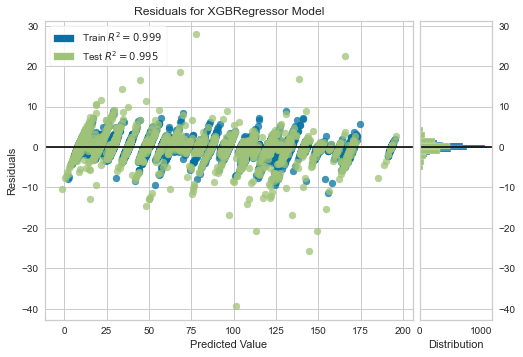

In [68]:
plot_model(xgb)

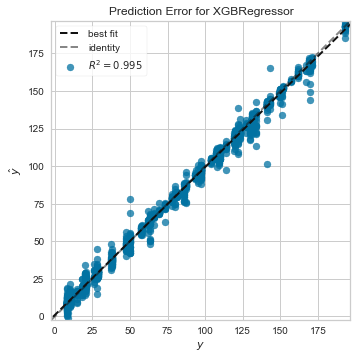

In [69]:
plot_model(xgb, plot = 'error')

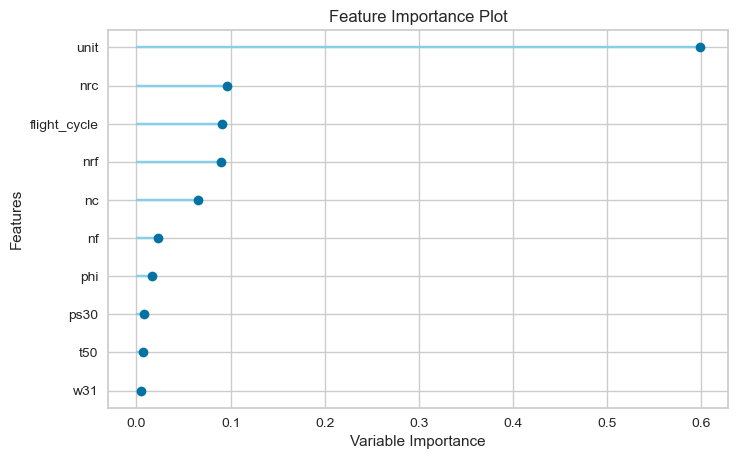

In [70]:
plot_model(xgb, plot='feature')

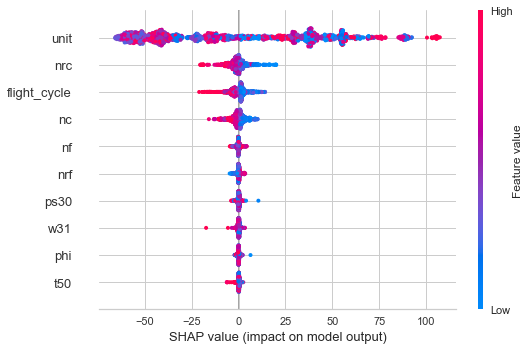

In [71]:
interpret_model(xgb)

In [72]:
evaluate_model(xgb)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [73]:
predict_model(xgb)

Model     MAE      MSE    RMSE      R2   RMSLE    MAPE
0  Extreme Gradient Boosting Regressor  2.1322  12.9081  3.5928  0.9951  0.1389  0.0649

unit  flight_cycle       t50        nf        nc      ps30       phi       nrf       nrc       w31    rul       Label
0    -1.579649     -0.886277  0.541165  1.020714 -1.074321  0.926929 -0.175295  0.170019 -0.944418  0.342115  132.0  132.746994
1     0.899214     -1.158040 -1.307200 -0.003539 -0.985020 -0.887069 -0.420130 -0.178439 -0.313789  1.530240   73.0   72.870003
2    -0.427501     -1.248627 -0.865999  0.850005 -0.731262 -1.844456  0.978923 -0.875357 -0.430167  0.272226   18.0   17.955999
3    -1.509822     -0.288400 -1.235337 -1.539917  0.023821 -0.836680  1.188781 -1.920733  0.657021  1.670019  107.0  105.881203
4     1.457831     -1.103687 -0.282745  0.337879 -1.059290 -0.383181  0.664136 -0.178439 -0.961327  0.412005  141.0  142.601196
...        ...           ...       ...       ...       ...       ...       ...       ...       ...       ...    ...         ...
1568 -0.252934     -1.357332  0.818586 -0.857083  0.432309  0.674985 -0.944774 -0.178439  0.504835 -0.846009   47.0   48.822601
1569  0.689733      0.400064 -0.028720 -0.515665 -0.053986 -0.433569  0.296885 -0.352669  0.140781  0.062557  169.0  168.051697
1570 -0.846464      1.613935  1.179569 -0.174248  1.268736 -0.635125 -0.140319  0.692707  1.222001  0.132446  127.0  126.671700
1571  1.388004      0.400064  0.979023  0.337879 -0.819679  0.120708 -1.067191 -0.178439  0.305899 -0.217002   97.0   88.322098
1572  1.178523     -0.904395 -1.193557 -1.539917 -0.228168 -1.390957  1.398639 -1.398045  0.099999  0.272226  131.0  131.082596

[1573 rows x 12 columns]

In [74]:
final_xgb = finalize_model(xgb)